 # Trapazoidal motion profile generation
 
 Generate a motion profile (sequence of positions and velocities from point A to point B) with a few constraints:
  - speed may not exceed a specified maximum
  - acceleration may not exceed a specified maximum
  - the path must a continuous function
  - integrating velocity must yield position 

In [1]:
from collections import namedtuple
Waypoint = namedtuple("Waypoint",
                      ["time", "linear_velocity", "linear_dist",
                       "angular_velocity", "angular_dist", "done"])

def assert_near(a, b, e=0.01):
    assert abs(a - b) < abs(e), (a, b)

In [2]:
import math

def signum(x):
    return -1 if x < 0 else 1

def gen_profile(dist, angle, v_max, a_max):
    """
    Generate a motion profile that should approach (dist, angle)
    without exceeding a maximum velocity or acceleration
    """
    t_0 = 0.0
    dist_ramp = 0.5 * v_max * (v_max / a_max) * signum(dist) # upper bound on distance we could travel while accelerating
    if abs(2 * dist_ramp) < abs(dist):
        # the move is long enough to get up to speed
        t_1 = v_max / a_max
        dist_during_const_vel = dist - (2 * dist_ramp)
        t_2 = abs(dist_during_const_vel) / v_max + t_1
        t_3 = t_2 + t_1
    else:
        # the move is not long enough so speed up then slow down (triangular profile)
        t_1 = math.sqrt(abs(dist / a_max))
        t_2 = t_1
        t_3 = 2.0 * t_1
        
    def ret(t):
        """
        Given an input time |t|:
        if t < t_0:
            we are pre move (somehow?).  Return a zero goal
        if t_0 < t < t_1
            we are in the constant acceleration portion.  Return an accelerating goal
        if t_1 < t < t_2
            we are in the constant velocity portion.  Return a constant velocity goal
        if t_2 < t < t_3
            we are in constant decceleration portion.  Return deccelerating goal
        if t_3 < t
            we are post move.  Return the end goal
        """
        
        if t < t_0:
            return Waypoint(t, 0, 0, 0, 0, False)
        elif t_0 <= t < t_1:
            velocity_now = a_max * t
            dist_now = 0.5 * t * velocity_now
            
            doneness = dist_now / dist * signum(dist) * signum(angle)
            angle_now = angle * doneness
            angle_vel_now = velocity_now * angle / dist * signum(dist) * signum(angle)
            return Waypoint(t,
                            velocity_now * signum(dist),
                            dist_now * signum(dist),
                            angle_vel_now * signum(angle),
                            angle_now * signum(angle),
                            False)
        elif t_1 <= t < t_2:
            velocity_now = v_max
            time_in_phase = t - t_1
            dist_in_phase = time_in_phase * velocity_now
            dist_now = abs(dist_ramp) + dist_in_phase
            
            doneness = dist_now / dist * signum(dist) * signum(angle)
            angle_now = angle * doneness
            angle_vel_now = velocity_now * angle / dist * signum(dist) * signum(angle)
            return Waypoint(t,
                            velocity_now * signum(dist),
                            dist_now * signum(dist),
                            angle_vel_now * signum(angle),
                            angle_now * signum(angle),
                            False)
        elif t_2 <= t < t_3:
            time_till_end = t_3 - t
            velocity_now = a_max * time_till_end
            dist_till_end = 0.5 * time_till_end * velocity_now
            dist_now = abs(dist) - dist_till_end
            
            doneness = dist_now / dist * signum(dist) * signum(angle)
            angle_now = angle * doneness
            angle_vel_now = velocity_now * angle / dist * signum(dist) * signum(angle)
            return Waypoint(t,
                            velocity_now * signum(dist),
                            dist_now * signum(dist),
                            angle_vel_now * signum(angle),
                            angle_now * signum(angle),
                            False)
        elif t_3 <= t:
            return Waypoint(t, 0, dist, 0, angle, True)
        else:
            raise Exception("bamboozled again")
    return ret

In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import csv, os

def graph_profile(points):
    times = [x.time for x in points]
    lin_vels = [x.linear_velocity for x in points]
    lin_dsts = [x.linear_dist for x in points]
    ang_vels = [x.angular_velocity for x in points]
    ang_dsts = [x.angular_dist for x in points]
    
    plt.subplot(2, 1, 1)
    plt.title('Linear and Angular velocity over time (trapazoidal)')
    plt.plot(times, lin_vels, '-', label="linear")
    plt.plot(times, ang_vels, '-', label="angular")
    plt.ylabel('velocity')
    plt.subplot(2, 1, 2)
    plt.title('Linear and Angular distance over time')
    plt.plot(times, lin_dsts, '-', label="linear")
    plt.plot(times, ang_dsts, '-', label="angular")

    plt.show()
    
def assert_vel_integral(points):
    """
    Assume constant timestep
    Assert that the integral of velocity is about equal to the distance at every step
    """
    timestep = points[1].time - points[0].time
    dist_integral = 0.0
    angle_integral = 0.0
    prev = points[0]
    for point in points:
        dist_integral += (point.linear_velocity + prev.linear_velocity) / 2.0 * timestep
        angle_integral += (point.angular_velocity + prev.angular_velocity) / 2.0 * timestep
        assert_near(angle_integral, point.angular_dist)
        assert_near(dist_integral, point.linear_dist)
        prev = point

def assert_dist_range(points, arguments):
    """
    Assert that the beginning and end of the profile are as expected (does it get there ever?)
    """
    assert points[0].linear_dist == 0
    assert points[0].angular_dist == 0
    assert points[-1].linear_dist == arguments[0]
    assert points[-1].angular_dist == arguments[1]

def assert_v_a_constraints(points, arguments):
    """
    Assert that at no point velocity exceeds maximum velocity
    and that at no point acceleration exceeds maximum acceleration
    """
    prev = points[0]
    for point in points:
        assert(abs(point.linear_velocity) <= abs(arguments[2]))
        assert(abs(point.linear_velocity - prev.linear_velocity) <= abs(arguments[3]))
        prev = point
        
def test_gen_profile(arguments, timestep=0.05):
    """
    run through a profile with the given arguments
    and assert that it's a properly formed profile
    """
    generator = gen_profile(*arguments)
    points = []
    time = 0
    while True:
        pt = generator(time)
        points.append(pt)
        if pt.done:
            break
        time += timestep
    
    graph_profile(points)
    assert_vel_integral(points)
    assert_dist_range(points, arguments)
    assert_v_a_constraints(points, arguments)

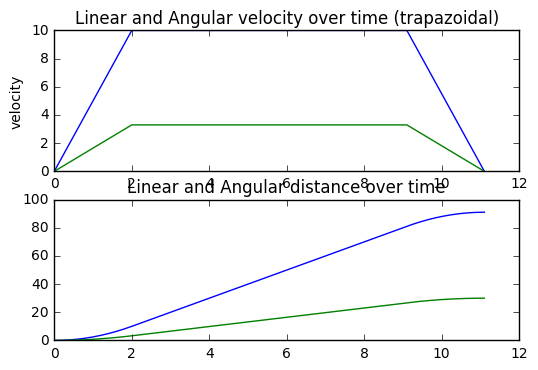

In [4]:
"""
Most boring case: positive distance, positive angle,
profile runs long enough to get up to speed for some time
"""

test_gen_profile((91, 30, 10, 5))

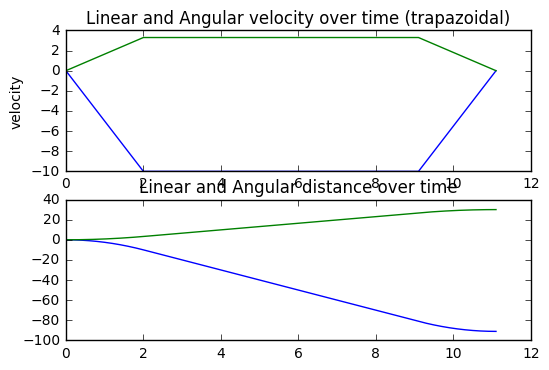

In [5]:
"""
Negative distance, positive angle
profile runs long enough to get up to speed for some time
"""


test_gen_profile((-91, 30, 10, 5))

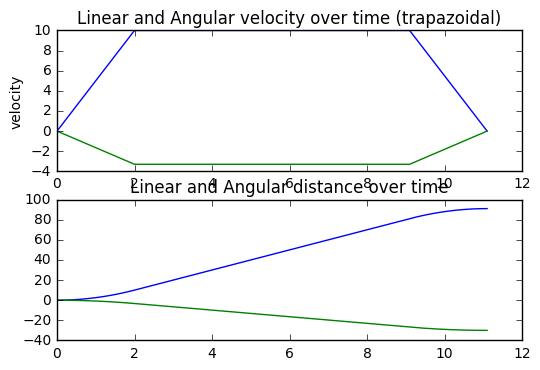

In [6]:
"""
Positive distance, negative angle
profile runs long enough to get up to speed for some time
"""

test_gen_profile((91, -30, 10, 5))

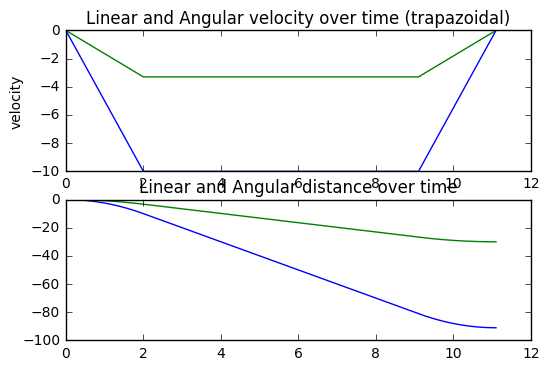

In [7]:
"""
Negative distance, negative angle
profile runs long enough to get up to speed for some time
"""

test_gen_profile((-91, -30, 10, 5))

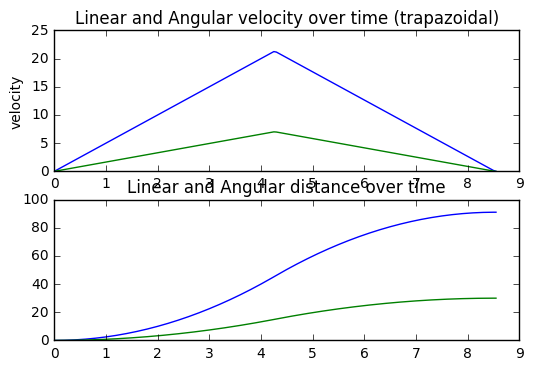

In [8]:
"""
Positive distance, positive angle
profile does not run long enough to get up to speed (triangular profile)
"""

test_gen_profile((91, 30, 100, 5))

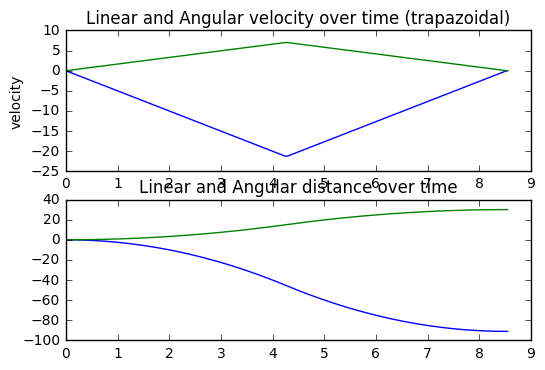

In [9]:
"""
Negative distance, positive angle
profile does not run long enough to get up to speed (triangular profile)
"""

test_gen_profile((-91, 30, 100, 5))

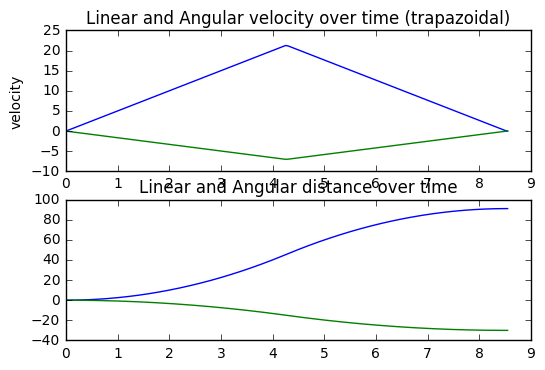

In [10]:
"""
Positive distance, negative angle
profile does not run long enough to get up to speed (triangular profile)
"""

test_gen_profile((91, -30, 100, 5))

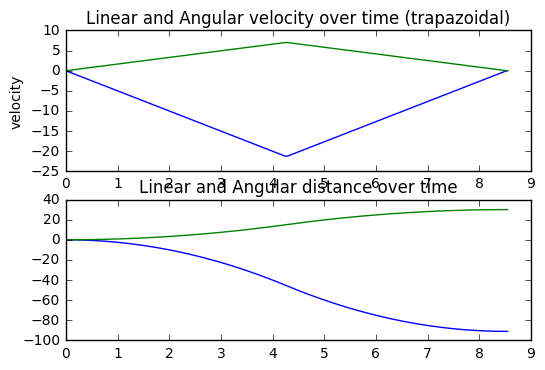

In [11]:
"""
Negative distance, positive angle
profile does not run long enough to get up to speed (triangular profile)
"""

test_gen_profile((-91, 30, 100, 5))